In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import GPy
from BNN_Dropout import NN_Dropout, BNN_Dropout
from BNN_SGDHMC import BNN_SGDHMC
from BNN_SVI import BNN_SVI

from Benchmark import RandomNN
from pybnn.bohamiann import Bohamiann

plt.rcParams['figure.figsize'] = (12.0, 8)


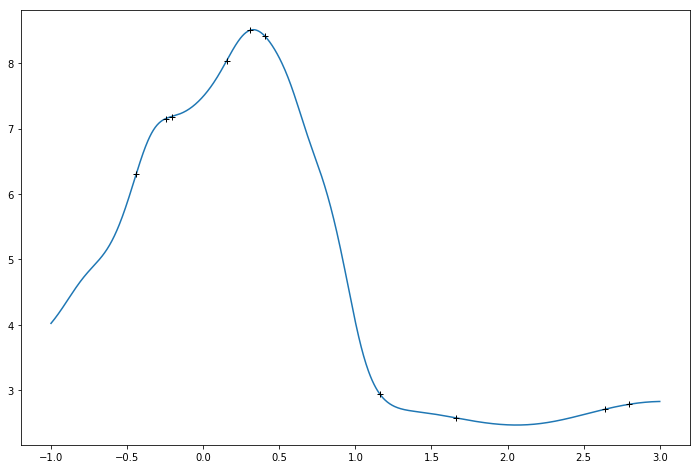

In [6]:
bench = RandomNN(1,3,50,nn.Tanh())
bench.rand_normal_weight(0.6)
num_plot  = 1000
num_train = 10
x = torch.linspace(-1,3,num_plot)[:,None]
y = bench(x)
train_id = np.random.permutation(num_plot)[:num_train]
train_x = x[train_id]
train_y = y[train_id]
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')

In [7]:
conf = dict()
conf['num_epochs'] = 1600
conf['num_hidden'] = 50
conf['num_layers'] = 3
conf['batch_size'] = 128


conf['dropout_rate'] = 0.01
conf['lr']           = 0.1
conf['tau']          = 1.5 #0.15
conf['lscale']       = 0.25


model = BNN_Dropout(1,nn.Tanh(), conf)

conf_hmc = dict()
hmc_model = BNN_SGDHMC(dim = 1, act = nn.Tanh(), conf = conf_hmc)
kern = GPy.kern.RBF(input_dim = 1)
gp = GPy.models.GPRegression(X=train_x.numpy(), Y= train_y.detach().numpy(), kernel=kern)
gp.likelihood.variance = 1e-2

conf_svi = dict()
conf_svi['num_iters'] = 1600
conf_svi['lr'] = 1e-4
svi_model = BNN_SVI(dim = 1, act = nn.Tanh(), conf = conf_svi)

In [8]:
svi_model.train(train_x, train_y)
hmc_model.train(train_x, train_y)
model.train(train_x, train_y)
gp.optimize()

torch.Size([10, 1])
torch.Size([10, 1])
[iteration 0001] loss: 269.6032


RuntimeError: shape mismatch: value tensor of shape [10, 1] cannot be broadcast to indexing result of shape [1000, 1]

In [ ]:
#py = model.predict(x)
py,pv = model.predict_mv(x)
ps = torch.sqrt(pv)
m_hmc,v_hmc = hmc_model.predict_mv(x)
m_hmc = m_hmc.detach().numpy().reshape(num_plot)
s_hmc   = v_hmc.sqrt().detach().numpy().reshape(num_plot)
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')


plt.subplot(131)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(),py.detach().numpy(),label = 'Pred')
plt.fill_between(
    x.numpy().reshape(num_plot), 
    (py - ps).reshape(num_plot).detach().numpy(), 
    (py + ps).reshape(num_plot).detach().numpy(), alpha = 0.1)
for i in range(50):
    net = model.sample()
    py  = net((x - model.x_mean) / model.x_std) * model.y_std + model.y_mean
    plt.plot(x.numpy(),py.detach().numpy(), 'g', alpha = 0.2)
plt.title('MC-dropout')

plt.subplot(132)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(x.numpy(), m_hmc)
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), m_hmc + s_hmc, m_hmc - s_hmc, alpha = 0.2)
plt.title('SGD-HMC')

plt.subplot(133)
gp_m, gp_v = gp.predict(x.numpy())
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')
plt.plot(x.numpy(), gp_m, label = 'GP prediction')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), (gp_m - np.sqrt(gp_v)).reshape(num_plot), (gp_m + np.sqrt(gp_v)).reshape(num_plot), alpha = 0.1)
plt.legend()
plt.title('Gaussian process')

In [83]:
np.sqrt(1/0.15)

2.581988897471611